VEM inference for the covariate-dependent LNMMSBM
=====

In [1]:
using Plots
#using PlotlyJS
using Random, Distributions, StatsBase, LinearAlgebra, DelimitedFiles, Optim
Random.seed!()

TaskLocalRNG()

In [2]:
# get observed data and known covariates
io = open("../data/input/X.txt","r")
X = readdlm(io, Float64)
close(io)
X = X[:,1:600]

io = open("../data/input/Y.txt","r")
Y = readdlm(io, Float64)
close(io)
Y = Y[1:600,1:600]

N = length(X[1,:])
P = length(X[:,1])
K = 4     # I know that the data was generate with K = 4. In principle one should do model selection to discover it

4

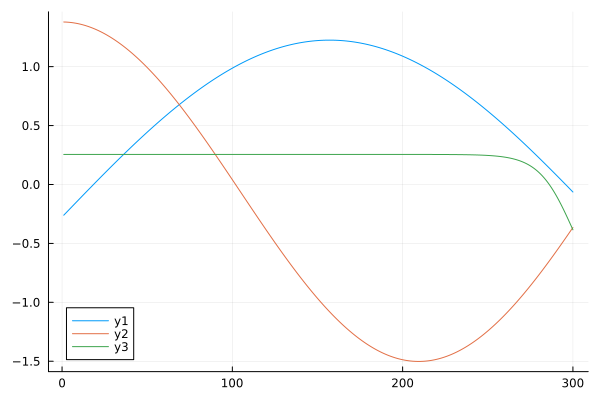

In [40]:
plot(X[1,:])
plot!(X[2,:])
plot!(X[3,:])
#plot!(X[4,:])

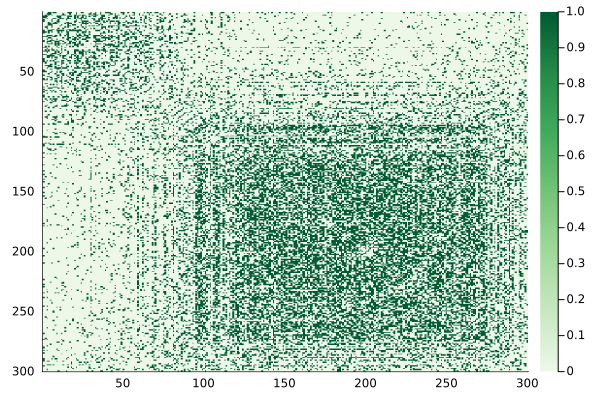

In [41]:
heatmap(Y, yflip=true,c = :Greens_7)

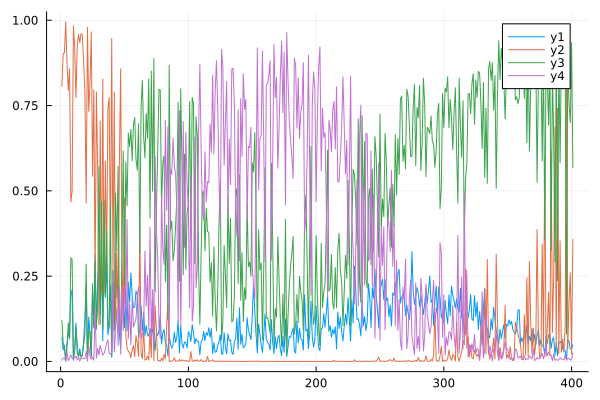

In [7]:
io = open("../data/ground_truth/theta.txt","r")
D = readdlm(io, Float64)
close(io)
plot(D[1,250:650])
plot!(D[2,250:650])
plot!(D[3,250:650])
plot!(D[4,250:650])

Variational Inference algorithm
=======
For now we deal with simplified case in which the graph is binary. Poisson was giving me numerical problems and i'm not even sure it is a proper noise model for Hi-C data.

In [3]:
# variational parameters for the E-step
ϕ = ones(N,N,K) #.* 1/K  # initialized as uniform distributions
for i in 1:N
    for j in 1:N
        ϕ[i,j,:] = rand(Dirichlet(K,1.0))
    end
end
λ = randn(N,K)    # mean vectors for the gaussians for every node
ν = [Matrix(1.0I, K, K) for i in 1:N] # covariance matrices for the gaussians. This is a vector of matrices

# parameters to be optimized in the M-step
#Σ = Matrix(1.0I, K, K)    # global covariance matrix
Σ = rand(Wishart(K,Matrix(.5I,K, K)))
σ_2 = rand(Gamma(1,1), K);      # prior covariance on the transformation coefficients Γ

B = zeros(K,K)
for k in 1:K
    for g in 1:k
        B[k,g] = rand()*0.04
        B[g,k] = B[k,g]
    end
end
B .+= Matrix(1.0I, K, K)*0.8
ρ = 0.1

Γ = zeros(K,P)
for k in 1:K
    Γ[k,:] .= randn(P)* sqrt(σ_2[k])
end

μ = Γ * X;
for i in 1:N
    ϕ[i,i,:] .= 0
end

In [45]:
B = [[0.855, 0.040, 0.024, 0.006] [0.040, 0.692, 0.035, 0.018] [0.024, 0.035, 0.885, 0.046] [0.006, 0.018, 0.046, 0.645]]

4×4 Matrix{Float64}:
 0.855  0.04   0.024  0.006
 0.04   0.692  0.035  0.018
 0.024  0.035  0.885  0.046
 0.006  0.018  0.046  0.645

In [7]:
B

4×4 Matrix{Float64}:
 0.836732    0.00382725  0.0393886   0.00137475
 0.00382725  0.83499     0.0271758   0.00679308
 0.0393886   0.0271758   0.811321    0.00470631
 0.00137475  0.00679308  0.00470631  0.813407

ELBO
---
We define now a function to compute the approximated ELBO, which we need to monitor in order to asses convergence of the optimization procedure. The explicit expression for it is 
\begin{align}
    \mathcal{L} 
    = & \frac{N}{2} \log |\pmb{\Sigma}^{-1}| - \frac{1}{2}\sum_{i=1}^N [ (\pmb{\lambda}_i - \pmb{\mu}_i)^T \pmb{\Sigma}^{-1} (\pmb{\lambda}_i - \pmb{\mu}_i) + \text{Tr}(\pmb{\Sigma}^{-1} \pmb{\nu}_i) ] + \sum_{i \neq j}^N \sum_{k=1}^K \phi_{ij,k} \lambda_{i,k} \\
    & - (N-1)\sum_{i=1}^N \left( \log \sum_{k'=1}^K \exp (\lambda_{i,k'}) + \frac{1}{2} \text{Tr}\{ ( \text{diag} (\pmb{\theta}(\pmb{\lambda}_i)) - \pmb{\theta}(\pmb{\lambda}_i) \pmb{\theta}(\pmb{\lambda}_i)^T ) \pmb{\nu}_i \} \right) \\
    & + \sum_{i=1}^N \sum_{j=1}^{i-1} \sum_{k,g=1}^K \phi_{ij,k} \phi_{ji,g} \log P (Y_{ij}| B_{k,g}, \rho) + \frac{1}{2} \sum_{i=1}^N \log |\pmb{\nu}_i| -\sum_{i \neq j }^N \sum_{k=1}^K \phi_{ij,k} \log \phi_{ij,k}
\end{align}


In [7]:
typeof(Y)

Matrix{Float64} (alias for Array{Float64, 2})

In [37]:
# approximate ELBO
function ELBO(ϕ::Array{Float64, 3}, λ::Array{Float64, 2}, ν::Vector{Matrix{Float64}},
    Σ::Array{Float64, 2}, σ_2::Array{Float64, 1}, B::Array{Float64, 2}, ρ::Float64, μ::Array{Float64, 2})
    apprELBO = 0.0
    inv_Σ = inv(Σ)
    apprELBO = 0.5 * N * log(det(inv_Σ))
    for i in 1:N
        apprELBO -= 0.5 * (dot(λ[i,:] .- μ[:,i], inv_Σ, λ[i,:] .- μ[:,i]) + tr(inv_Σ*ν[i])) #first 2 terms
    end
    
    for k in 1:K
        for j in 1:N
            for i in 1:N
                if i != j
                    apprELBO -= ϕ[i,j,k]*log(ϕ[i,j,k]) #last entropic term
                end
            end
        end
    end
    
    for j in 1:N
        for i in 1:N
            if i != j
                apprELBO += dot(ϕ[i,j,:],λ[i,:])# vcat(λ[i,:], 1.0)) #third term
            end
        end
    end
    
    for i in 1:N
        theta = zeros(K)
        theta .= exp.(λ[i,:])  #exp.(vcat(λ[i,:], 1.0))
        theta /= sum(theta)
        # second line of the expression above
        apprELBO -= (N-1) * ( (log(sum(exp.(λ[i,:])))) + 0.5*tr((diagm(theta) .- theta * theta')*ν[i]) )
        #gaussian entropic term
        apprELBO += 0.5*log(det(ν[i]))
    end
    
    #likelihood term
    logB = log.(B*(1-ρ))
    logB2 = log.(ones(K,K) .- (1-ρ)*B)
    for i in 1:N
        for j in 1:i-1
            for k in 1:K
                for g in 1:K
                    #logP = Y[i,j] * ( log(B[k,g]*(1-ρ)) - abs(i-j)/N) - B[k,g]*(1-ρ)*exp(-abs(i-j)/N)
                    #logP = Y[i,j]*log(B[k,g]*(1-ρ)) + (1-Y[i,j])*log(1-B[k,g]*(1-ρ))
                    logP = Y[i,j]*logB[k,g] + (1-Y[i,j])*logB2[k,g]
                    apprELBO += ϕ[i,j,k]*ϕ[j,i,g]*logP
                end
            end
        end
    end
    return apprELBO
end

ELBO (generic function with 2 methods)

In [30]:
@time ELBO(ϕ, λ, ν, Σ, σ_2, B, ρ, μ,Y)

  1.518893 seconds (56.79 M allocations: 1.030 GiB, 6.33% gc time)


-6.613471815042958e6

In [39]:
@time ELBO(ϕ, λ, ν, Σ, σ_2, B, ρ, μ)

  1.534586 seconds (56.79 M allocations: 1.030 GiB, 6.03% gc time)


-6.613471815042958e6

In [40]:
length(ϕ[1,1,:])

4

E-step: Newton's method to optimize $\{ \pmb{\mu}_i, \pmb{\nu}_i \}$ for $i=1 \ldots N$
---
The function we need to optimize is 
\begin{align}
    f(\pmb{\eta}_i) 
    = & -\frac{1}{2}(\pmb{\eta}_i - \pmb{\mu}_i)^T \pmb(\Sigma)^{-1} (\pmb{\eta}_i - \pmb{\mu}_i) + \sum_{j (\neq i)}^N \sum_{k=1}^K \left( \eta_{i,k} - \log \sum_{k'=1}^K \exp(\eta_{i,k'})\right) \mathbb{E}_{q(\pmb{z}_{ij})}[z_{ij,k}] \\
    = & -\frac{1}{2}(\pmb{\eta}_i - \pmb{\mu}_i)^T \pmb(\Sigma)^{-1} (\pmb{\eta}_i - \pmb{\mu}_i) + \pmb{\eta}_i \cdot \pmb{\phi}_i - (N-1) \log \sum_{k'=1}^K \exp(\eta_{i,k'})
\end{align}
where $\pmb{\phi}_i = \sum_{j(\neq i)}^N \pmb{\phi}_{ij}$.

The gradient and the Hessian are:
\begin{equation}
    \nabla f(\pmb{\eta}_i) =  - (N-1)\pmb{\theta}(\pmb{\eta}_i) + \sum_{j (\neq i)}^N \pmb{\phi}_{ij} -\pmb{\Sigma}^{-1}(\pmb{\eta}_i - \pmb{\mu}_i)
\end{equation}

\begin{equation}
    \nabla^2 f(\pmb{\eta}_i) =  -(N - 1) ( \text{diag} (\pmb{\theta}(\pmb{\eta}_i)) - \pmb{\theta}(\pmb{\eta}_i) \pmb{\theta}(\pmb{\eta}_i)^T ) - \pmb{\Sigma}^{-1} 
\end{equation}

If we use Newton's method for the optimization we need the recompute and invert many times the Hessian matrix, which can be very expensive. We could use quasi-Newton methods, where the Hessian is estimated 
and compute the true Hessian using the above formula as an iniziatilization for the BFGS optimization algorithm.
However notice that the function to be optimized is strictly convex. So the number of iterations for newton is quite small

In [10]:
# define the function to optimize
function f(η_i::Array{Float64, 1}, ϕ_i::Array{Float64, 1}, inv_Σ::Array{Float64, 2}, μ_i::Array{Float64},N::Int)
    f = 0.5 * dot(η_i .- μ_i, inv_Σ, η_i .- μ_i) - dot(η_i, ϕ_i) +(N-1)*log(sum(exp.(η_i)))
    return f
end


function gradf!(G, η_i::Array{Float64, 1}, ϕ_i::Array{Float64, 1}, inv_Σ::Array{Float64, 2}, μ_i::Array{Float64},N::Int)
    G .= exp.(η_i)/sum(exp.(η_i))*(N-1) .- ϕ_i .+ inv_Σ*(η_i .- μ_i) 
    #G .= -exp.(η_i)/sum(exp.(η_i)) .+ ϕ_i/(N-1) - inv_Σ*(η_i .- μ_i)/(N-1)
end

function hessf!(H, η_i::Array{Float64, 1}, inv_Σ::Array{Float64, 2}, μ_i::Array{Float64},N::Int)
    theta = exp.(η_i)/sum(exp.(η_i))
    H .=  (N-1)*(diagm(theta) .- theta*theta') .+ inv_Σ
    #H .= - (diagm(theta) .- theta*theta') .- inv_Σ/(N-1)
end

hessf! (generic function with 1 method)

Full Algorithm
====

In [51]:
n_iterations = 15
elbows = zeros(n_iterations)
elbows[1] = ELBO(ϕ, λ, ν, Σ, σ_2, B, ρ, μ)
println(elbows[1])
for i_iter in 2:n_iterations
    inv_Σ = inv(Σ)
    G = zeros(K)
    H = zeros(K,K) 
    for m in 1:1
        for i in 1:N
            for j in 1:N
                if i != j
                    for k in 1:K
                        logPi = λ[i,k] 
                        for g in 1:K
                            logPi += ϕ[j,i,g] * (Y[i,j]*log(B[k,g]*(1-ρ)) + (1-Y[i,j])*log(1-(1-ρ)*B[k,g])) 
                        end
                        ϕ[i,j,k] = exp(logPi)
                    end
                    ϕ[i,j,:] ./= sum(ϕ[i,j,:])

                    for k in 1:K
                        logPj = λ[j,k] 
                        for g in 1:K
                            logPj += ϕ[i,j,g] * (Y[j,i]*log(B[k,g]*(1-ρ)) + (1-Y[j,i])*log(1-(1-ρ)*B[k,g])) 
                        end
                        ϕ[j,i,k] = exp(logPj)
                    end
                    ϕ[j,i,:] ./= sum(ϕ[j,i,:])
                end
            end    
        end
    end
    
    for i in 1:N
        ϕ_i = sum(ϕ[i,:,:],dims=1)[1,:]
        μ_i = μ[:,i]
        res = optimize(η_i -> f(η_i, ϕ_i, inv_Σ, μ_i, N), (G, η_i) -> gradf!(G,η_i, ϕ_i, inv_Σ, μ_i, N), randn(K), BFGS())
        η_i = Optim.minimizer(res)
        hessf!(H, η_i, inv_Σ, μ_i, N)
        λ[i,:] .= η_i
        ν[i] .= inv(H)
    end
    ###################################################################

    ###################################################################
    #end
    for m in 1:5
        for k in 1:K
            Γ[k,:] = inv(X*X' + diagm(ones(P)/σ_2[k]))*(X*λ[:,k])
            σ_2[k] = (0.5 + sum(Γ[k,:].^2))/(0.5 + P)
        end
        
    end
    
    μ = Γ * X

    Σ .= zeros(K,K)
    for i in 1:N
        Σ .+= 1/N * (ν[i] .+ (λ[i,:] .- μ[:,i])*(λ[i,:] .- μ[:,i])')
    end

    for k in 1:K
        for g in 1:K
            num = 0.
            den = 0.
            for j in 1:N
                for i in 1:N
                    num += ϕ[i,j,k]*ϕ[j,i,g]*Y[i,j]
                    den += ϕ[i,j,k]*ϕ[j,i,g]
                end
            end
            B[k,g] = num/(den*(1-ρ))
        end
    end
    
    elbows[i_iter] = ELBO(ϕ, λ, ν, Σ, σ_2, B, ρ, μ)
    println(i_iter, " ELBO  ", elbows[i_iter])
    if isnan(elbows[i_iter]) 
        break
    end
    #println(ρ)
end

-25752.84883217023
2 ELBO  -25587.335269373318
3 ELBO  -25411.092121002566
4 ELBO  -25231.83335835339
5 ELBO  -25062.464915817676
6 ELBO  -24912.736110822763
7 ELBO  -24782.455962617867
8 ELBO  -24667.292153619626
9 ELBO  -24564.978345434192
10 ELBO  -24475.41219598113
11 ELBO  -24399.507176479703
12 ELBO  -24337.821267841126
13 ELBO  -24289.042544807297
14 ELBO  -24250.095148954035
15 ELBO  -24217.80341306235


In [31]:
el = vcat(el,elbows[2:end])

198-element Vector{Float64}:
 -201577.09169761708
  -46518.73520855908
  -38405.570142962475
  -37640.588132752826
  -37516.21752005499
  -37449.81984237342
  -37383.767339605765
  -37310.73076078968
  -37228.28225392354
  -37134.65572128843
  -37028.43154725652
  -36908.664178775456
  -36775.09819490258
       ⋮
  -29964.80155567299
  -29964.45301991896
  -29964.10941750467
  -29963.770637177302
  -29963.436571034283
  -29963.107114386374
  -29962.78216567336
  -29962.461626337226
  -29962.145400684905
  -29961.83339590438
  -29961.525521786276
  -29961.22169080216

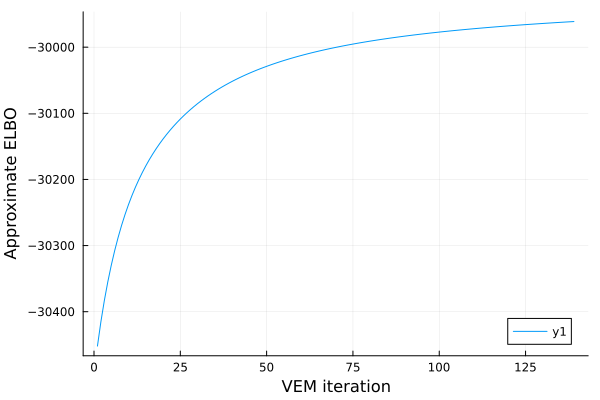

In [32]:
#plot(index,el[7:end], markers = 'o',legend=false, markersize=2.)
plot(el[60:end])
xlabel!("VEM iteration")
ylabel!("Approximate ELBO")
#savefig("ELBO_2.pdf")

In [55]:
B

4×4 Matrix{Float64}:
 0.481562   0.0738403  0.606826   0.0981125
 0.0738403  0.388256   0.0574889  0.130634
 0.606826   0.0574889  0.755038   0.106359
 0.0981125  0.130634   0.106359   0.0588231

In [270]:
σ_2

4-element Vector{Float64}:
 2.2921877687814347
 0.15852342422073365
 0.3031319335646171
 0.35612691236085653

In [34]:
Σ

4×4 Matrix{Float64}:
 5.87326   9.61672  4.41853   7.23158
 9.61672  15.9428   7.15889  11.9124
 4.41853   7.15889  3.35394   5.41281
 7.23158  11.9124   5.41281   8.93038

In [239]:
ν[4]

4×4 Matrix{Float64}:
 0.709411  0.535221  0.478818  0.473268
 0.535221  0.527639  0.524797  0.524454
 0.478818  0.524797  0.539834  0.541022
 0.473268  0.524454  0.541022  0.542635

In [52]:
thetas = zeros(N,K)
for i in 1:N
    thetas[i,:] .= exp.(λ[i,:]) ./ sum(exp.(λ[i,:]))
end

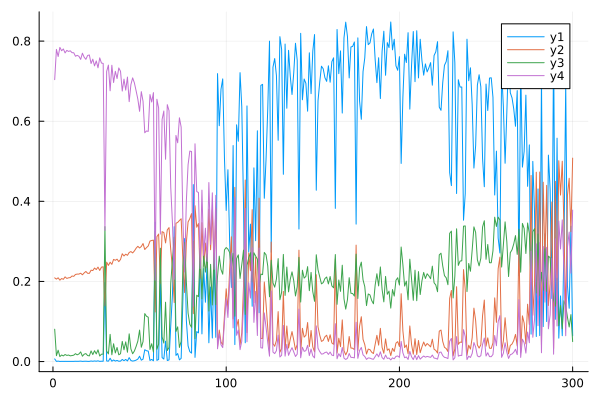

In [53]:
p1 = plot(thetas[:,3])
plot!(p1,thetas[:,4])
plot!(p1,thetas[:,1])
plot!(p1,thetas[:,2])

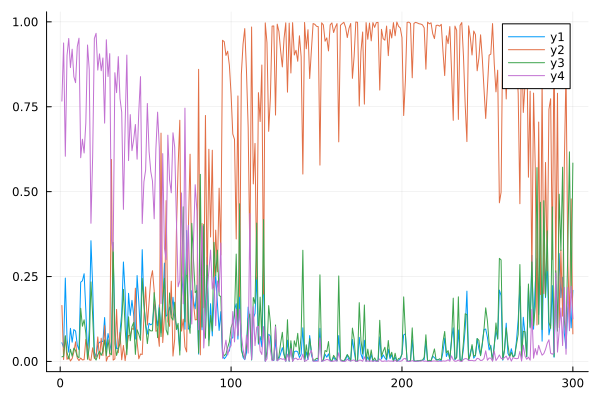

In [54]:
io = open("../data/ground_truth/theta.txt","r")
D = readdlm(io, Float64)
close(io)
p2 = plot(D[1,1:300])
plot!(p2, D[2,1:300])
plot!(p2, D[3,1:300])
plot!(p2, D[4,1:300])

In [48]:
theta_plot = [p1, p2]

2-element Vector{Plots.Plot{Plots.GRBackend}}:
 Plot{Plots.GRBackend() n=4}
 Plot{Plots.GRBackend() n=4}

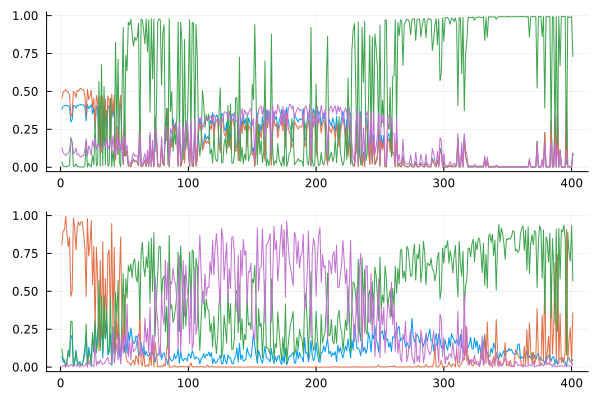

In [286]:
plot(theta_plot..., layout = (2,1), legend=false)#, aspect_ratio=:equal)
#savefig("topic_poportions_2.pdf")

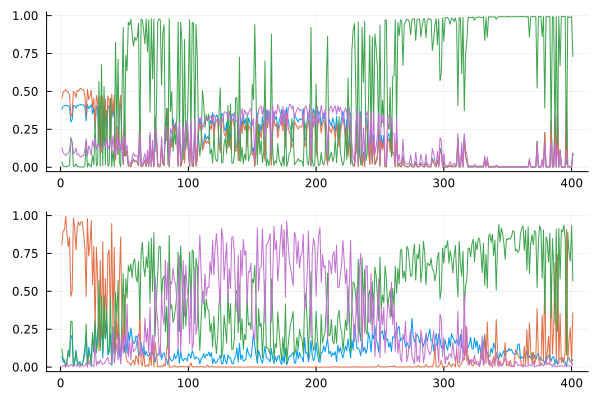

In [275]:
plot(theta_plot..., layout = (2,1), legend=false)#, aspect_ratio=:equal)
#savefig("topic_poportions.pdf")

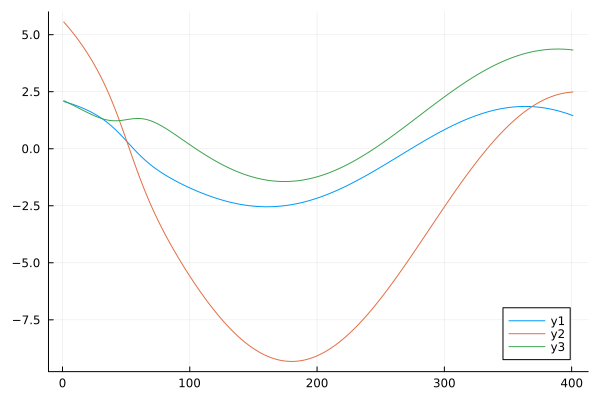

In [276]:
io = open("../data/ground_truth/mu.txt","r")
D = readdlm(io, Float64)
close(io)
plot(D[1,250:650])
plot!(D[2,250:650])
plot!(D[3,250:650])
#plot!(D[4,1:500])

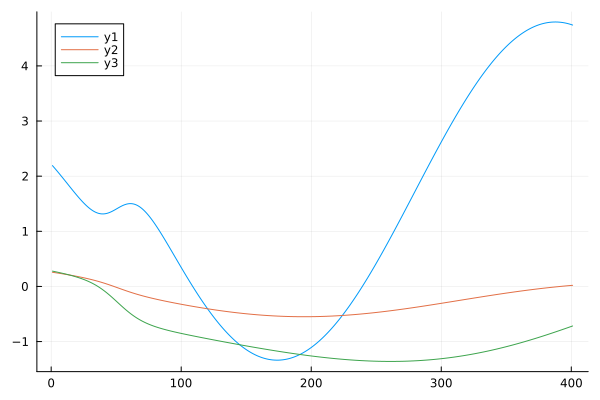

In [277]:
mu = Γ*X
plot(mu[1,:])
plot!(mu[2,:])
plot!(mu[3,:])



In [56]:
A_pred = zeros(N,N)
A_expected = zeros(N,N)
for i in 1:N
    for j in 1:i-1
        z_i = sample(Weights(thetas[i,:]))
        z_j = sample(Weights(thetas[j,:]))
        
        rate = B[z_i,z_j] *(1-ρ) #*exp(-abs(i-j)/(N))
        if rand() < rate
            A_pred[i,j] = 1
            A_pred[j,i] = A_pred[i,j]
        end
        A_expected[i,j] = rate 
        A_expected[j,i] = A_expected[i,j]
    end
end

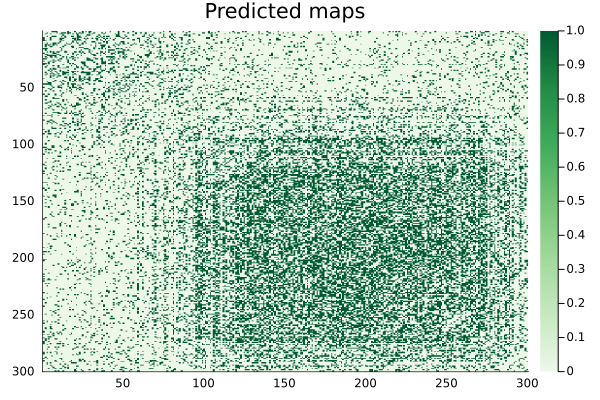

In [57]:
hm_pred = heatmap(A_pred, yflip=true,c = :Greens_7, title = "Predicted maps")


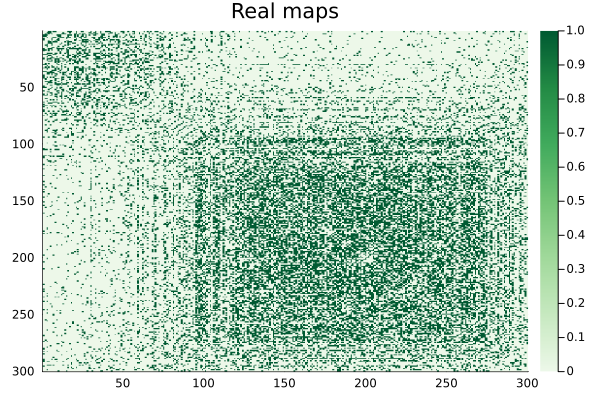

In [58]:
hm_obs = heatmap(Y, yflip=true,c = :Greens_7, title = "Real maps") # obs

In [281]:
hm = [hm_pred, hm_obs]

2-element Vector{Plots.Plot{Plots.GRBackend}}:
 Plot{Plots.GRBackend() n=1}
 Plot{Plots.GRBackend() n=1}

In [283]:
plot(hm..., layout = (2,2))#, aspect_ratio=:equal)
#savefig("maps_comparison_2.pdf")

"/home/alex-zhang/PhD/generative_model_for_hic_reads/LLMMSMB-covariates/src/maps_comparison_2.pdf"

In [21]:
isfile("../data/preliminary_results/prova_exists.txt")

true

In [27]:
open("../data/preliminary_results/elbows.txt", "a") do io 
    writedlm(io, elbows')
end

In [104]:
i,j = samplepair(N)
println(i," ",j)
println(ϕ[i,j,:], ϕ[j,i,:])
println("\n")
for mm in 1:5
    for k in 1:K
        logPi = λ[i,k] 
        for g in 1:K
            logPi += ϕ[j,i,g] * (Y[i,j]*log(B[k,g]*(1-ρ)) + (1-Y[i,j])*log(1-(1-ρ)*B[k,g])) 
        end
        ϕ[i,j,k] = exp(logPi)
    end
    ϕ[i,j,:] ./= sum(ϕ[i,j,:])

    for k in 1:K
        logPj = λ[j,k] 
        for g in 1:K
            logPj += ϕ[i,j,g] * (Y[j,i]*log(B[k,g]*(1-ρ)) + (1-Y[j,i])*log(1-(1-ρ)*B[k,g])) 
        end
        ϕ[j,i,k] = exp(logPj)
    end
    ϕ[j,i,:] ./= sum(ϕ[j,i,:])
    println(ϕ[i,j,:], ϕ[j,i,:])
end

148 595
[0.33670970858285454, 0.22283295377142764, 0.026082856827317782, 0.41437448081839995][0.32522959117676375, 0.2566793756974694, 0.044199428257620334, 0.37389160486814654]


[0.3380198613178297, 0.2232585075420503, 0.025866573890161327, 0.4128550572499586][0.3265216677891329, 0.2563461160504611, 0.04423710065612212, 0.37289511550428384]
[0.3380176602973458, 0.2232583616306198, 0.02586702808652085, 0.41285694998551364][0.32652167134608495, 0.25634611972596755, 0.04423710084168049, 0.372895108086267]
[0.338017660284765, 0.22325836162989918, 0.025867028093926974, 0.4128569499914089][0.3265216713460926, 0.25634611972601634, 0.04423710084170987, 0.37289510808618126]
[0.3380176602847648, 0.22325836162989934, 0.025867028093927144, 0.4128569499914087][0.3265216713460926, 0.2563461197260163, 0.04423710084170987, 0.3728951080861812]
[0.3380176602847648, 0.22325836162989934, 0.025867028093927158, 0.4128569499914087][0.3265216713460926, 0.2563461197260163, 0.04423710084170987, 0.372895108086

Let's try a stochastic version of the algorithm
=======
The algorithm above scales quadratically with the number of nodes in the graph. Can we implement a stochastic and more scalable version by subsampling the graph?

In [ ]:
n_iterations = 100
elbows = zeros(n_iterations)
elbows[1] = ELBO(ϕ, λ, ν, Σ, σ_2, B, ρ, μ)
println(elbows[1])
for i_iter in 2:n_iterations
    inv_Σ = inv(Σ)
    G = zeros(K)
    H = zeros(K,K) 
    #for i in 1:N
        #for j in 1:N
            #if i != j
    for m in 1:300000
        i,j = samplepair(N)
        for k in 1:K
            logPi = λ[i,k] 
            for g in 1:K
                logPi += ϕ[j,i,g] * (Y[i,j]*log(B[k,g]*(1-ρ)) + (1-Y[i,j])*log(1-(1-ρ)*B[k,g])) 
            end
            ϕ[i,j,k] = exp(logPi)
        end
        ϕ[i,j,:] ./= sum(ϕ[i,j,:])

        for k in 1:K
            logPj = λ[j,k] 
            for g in 1:K
                logPj += ϕ[i,j,g] * (Y[j,i]*log(B[k,g]*(1-ρ)) + (1-Y[j,i])*log(1-(1-ρ)*B[k,g])) 
            end
            ϕ[j,i,k] = exp(logPj)
        end
        ϕ[j,i,:] ./= sum(ϕ[j,i,:])
    end
            #end
        #end    
    #end
    
    for i in 1:N
        ϕ_i = sum(ϕ[i,:,:],dims=1)[1,:]
        μ_i = μ[:,i]
        res = optimize(η_i -> f(η_i, ϕ_i, inv_Σ, μ_i, N), (G, η_i) -> gradf!(G,η_i, ϕ_i, inv_Σ, μ_i, N), randn(K), BFGS())
        η_i = Optim.minimizer(res)
        hessf!(H, η_i, inv_Σ, μ_i, N)
        λ[i,:] .= η_i
        ν[i] .= inv(H)
    end
    ###################################################################

    ###################################################################
    #end
    for m in 1:5
        for k in 1:K
            Γ[k,:] = inv(X*X' + diagm(ones(P)/σ_2[k]))*(X*λ[:,k])
            σ_2[k] = (0.5 + sum(Γ[k,:].^2))/(0.5 + P)
        end
        
    end
    
    μ = Γ * X

    Σ .= zeros(K,K)
    for i in 1:N
        Σ .+= 1/N * (ν[i] .+ (λ[i,:] .- μ[:,i])*(λ[i,:] .- μ[:,i])')
    end

    for k in 1:K
        for g in 1:K
            num = 0.
            den = 0.
            for m in 1:25000
                i,j = samplepair(N)
                num += ϕ[i,j,k]*ϕ[j,i,g]*Y[i,j]
                den += ϕ[i,j,k]*ϕ[j,i,g]
            end
            B[k,g] = num/(den*(1-ρ))
        end
    end
    
    elbows[i_iter] = ELBO(ϕ, λ, ν, Σ, σ_2, B, ρ, μ)
    println(i_iter, " ELBO  ", elbows[i_iter])
    if isnan(elbows[i_iter]) 
        break
    end
    #println(ρ)
end

-257339.99922069843
2 ELBO  -257342.31185808292
3 ELBO  -257338.34110214032
4 ELBO  -257338.74751818844
5 ELBO  -257341.46925233386
6 ELBO  -257341.00445490394
7 ELBO  -257335.68847040276
8 ELBO  -257338.0560618435
9 ELBO  -257337.73569703518
10 ELBO  -257338.6905374961
11 ELBO  -257336.31987425833
12 ELBO  -257340.25696331848
13 ELBO  -257337.34769130632
14 ELBO  -257337.53881812445
15 ELBO  -257335.90239083604
16 ELBO  -257337.23516777196
17 ELBO  -257336.1392613871
18 ELBO  -257332.17341486682
19 ELBO  -257335.62919597642
20 ELBO  -257335.14071843546
21 ELBO  -257336.45376835894
22 ELBO  -257335.94808695678
23 ELBO  -257333.2753135782
24 ELBO  -257334.01818356596
25 ELBO  -257333.67431735838
26 ELBO  -257335.3396646014
27 ELBO  -257332.08529548062
28 ELBO  -257333.06425692732
29 ELBO  -257334.85884365972
30 ELBO  -257335.08016124615
31 ELBO  -257332.47787346764
32 ELBO  -257328.90471517775
33 ELBO  -257336.15459476184
34 ELBO  -257335.81521574312
35 ELBO  -257334.4916286513
36 ELBO 

In [116]:
el = vcat(el,elbows[2:end])

574-element Vector{Float64}:
 -267140.52733038645
 -267130.25037107937
 -267125.28885872883
 -267118.4745442756
 -267111.6568424982
 -267104.5236297456
 -267099.24601714255
 -267089.71203162335
 -267084.16210693575
 -267081.125391634
 -267076.2978004809
 -267065.92628281977
 -267061.4917209893
       ⋮
 -257342.23203432778
 -257338.88365883022
 -257342.7342616867
 -257343.29390662743
 -257343.43014110674
 -257339.48546529657
 -257344.1517663255
 -257338.18347812226
 -257341.72804098873
 -257343.26164386453
 -257343.11801109638
 -257339.99922069843

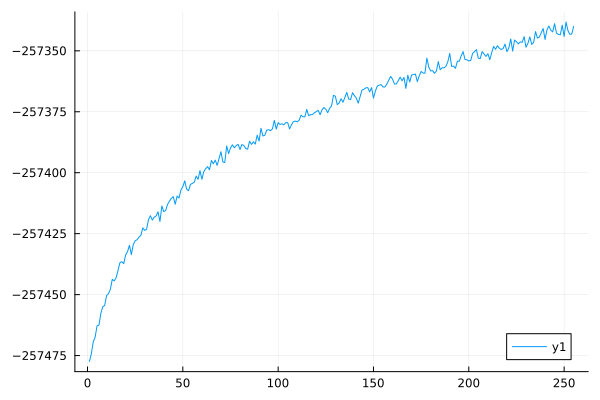

In [117]:
plot(el[320:end])

In [26]:
for samples in 1:10000
    ind = samplepair(N)
    ind[1], ind[2]
end

In [59]:
B

4×4 Matrix{Float64}:
 0.481562   0.0738403  0.606826   0.0981125
 0.0738403  0.388256   0.0574889  0.130634
 0.606826   0.0574889  0.755038   0.106359
 0.0981125  0.130634   0.106359   0.0588231

In [86]:
@time ELBO(ϕ, λ, ν, Σ, σ_2, B, ρ, μ)

  1.833283 seconds (76.92 M allocations: 1.330 GiB, 10.60% gc time)


-536897.9832847462

In [174]:
function fff()
    #logPi = 0.
#logPj = 0.
    logB = log.(B*(1-ρ))
    logB2 = log.(ones(K,K) .- (1-ρ)*B)
    for i in 1:N
        for j in 1:N
            if i != j
                for k in 1:K
                    logPi = λ[i,k] 
                    #ϕ[i,j,k] = exp(λ[i,k])
                    for g in 1:K
                        #logPi += ϕ[j,i,g] * (Y[i,j]*log(B[k,g]*(1-ρ)) + (1-Y[i,j])*log(1-(1-ρ)*B[k,g])) 
                        logPi += ϕ[j,i,g] * ((Y[i,j]*logB[k,g]) + (1-Y[i,j])*logB2[k,g])
                        #ϕ[i,j,k] *= ((B[k,g]*(1-ρ))^(Y[i,j]) * (1-(1-ρ)*B[k,g])^(1-Y[i,j]))^ϕ[j,i,g]
                    end
                    ϕ[i,j,k] = exp(logPi)
                end
                ϕ[i,j,:] ./= sum(ϕ[i,j,:])
            end
        end    
    end
end

fff (generic function with 1 method)

In [177]:
@time fff()

  2.423868 seconds (80.28 M allocations: 1.437 GiB, 5.76% gc time)


In [176]:
logB2 = log.(ones(K,K) .- (1-ρ)*B)

4×4 Matrix{Float64}:
 -0.315543  -0.230258  -0.13991   -0.190098
 -0.230258  -0.447936  -0.209791  -0.263809
 -0.13991   -0.209791  -0.257528  -0.154514
 -0.190098  -0.263809  -0.154514  -0.351289

In [55]:
function ggg()#ϕ,Y,ρ,B)
    for k in 1:K
        for g in 1:k
            num = 0.
            den = 0.
            for m in 1:180000
                i,j = samplepair(N)
                #phi_prod = ϕ[i,j,k]*ϕ[j,i,g]
                num += ϕ[i,j,k]*ϕ[j,i,g]*Y[i,j]
                den += ϕ[i,j,k]*ϕ[j,i,g]
            end
            B[k,g] = num/(den*(1-ρ))
            B[g,k] = B[k,g]
        end
    end
end

ggg (generic function with 1 method)

In [54]:
@time ggg()#ϕ,Y,ρ,B)

  0.530204 seconds (14.94 M allocations: 255.364 MiB, 4.58% gc time)


In [59]:
@time ggg()#ϕ,Y,ρ,B)

  0.647070 seconds (18.53 M allocations: 310.265 MiB, 4.74% gc time)


In [200]:
B_full = B

4×4 Matrix{Float64}:
 0.252171  0.253515  0.185682  0.219726
 0.253515  0.327392  0.228012  0.267909
 0.185682  0.228012  0.194309  0.189613
 0.219726  0.267909  0.189613  0.253849

In [65]:
Bs = zeros(K,K,20)
for trial in 1:20
    for k in 1:K
        for g in 1:K
            num = 0.
            den = 0.
            for m in 1:900
                i,j = samplepair(N)
                num += ϕ[i,j,k]*ϕ[j,i,g]*Y[i,j]
                den += ϕ[i,j,k]*ϕ[j,i,g]
            end
            B[k,g] = num/(den*(1-ρ))
        end
    end
    Bs[:,:,trial] = B 
end
Bs

4×4×20 Array{Float64, 3}:
[:, :, 1] =
 0.51891    0.0541194  0.595217   0.112717
 0.0595778  0.407816   0.0659979  0.135514
 0.600534   0.0682461  0.767298   0.079431
 0.0813503  0.128303   0.119505   0.0559681

[:, :, 2] =
 0.461177   0.09374    0.64115    0.0973949
 0.0740274  0.483229   0.0596925  0.128138
 0.602599   0.0582494  0.773572   0.109402
 0.0991673  0.128941   0.0750975  0.0615726

[:, :, 3] =
 0.497006   0.0654005  0.569018   0.0887626
 0.0802943  0.355409   0.0643087  0.148237
 0.528241   0.0511423  0.728727   0.106887
 0.0949679  0.128762   0.0934964  0.0688949

;;; … 

[:, :, 18] =
 0.474469   0.0789642  0.621909   0.0868194
 0.0692774  0.464297   0.0409865  0.135239
 0.594473   0.0442129  0.758011   0.100142
 0.0962522  0.11015    0.134711   0.0691964

[:, :, 19] =
 0.509768   0.0792121  0.595823   0.105714
 0.0822923  0.462399   0.0576947  0.136552
 0.620986   0.0598166  0.796484   0.102818
 0.112058   0.143989   0.116106   0.0576632

[:, :, 20] =
 0.486071   0.0656

In [66]:
B_mean = mean(Bs, dims=3)

4×4×1 Array{Float64, 3}:
[:, :, 1] =
 0.482653   0.0721921  0.609333   0.0996663
 0.0764926  0.394673   0.0557518  0.129529
 0.602267   0.0540123  0.75688    0.105474
 0.0974445  0.12601    0.102573   0.0590651

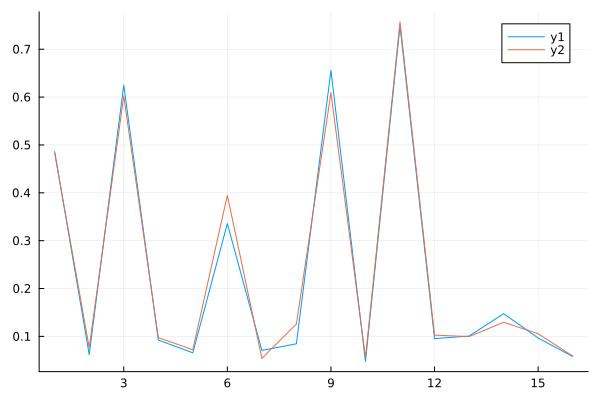

In [67]:
plot(vcat(B_full...))
plot!(vcat(B_mean...))